This notebook is used to construct a SeriesPipeline which aims to detect whether a wearable is on the wrist or not.

In [1]:
import sys

import numpy as np
import pandas as pd

sys.path.append("../../")

import plotly.graph_objects as go
from functional import seq
from IPython.display import display
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler
from tsflex.processing import get_processor_logs

from code_utils.empatica.nonwear import wrist_pipeline, wrist_pipeline_bottcher
from code_utils.path_conf import processed_etri_path

## Backtest the non-wear detection pipeline on an excerpt

In [2]:
user = "user02"
date_s = "2020_09_13"

# print out all the dates
print(
    seq((processed_etri_path / user).glob("e4Acc_*"))
    .map(lambda x: "_".join(x.stem.split("_")[1:]))
    .to_list()
)

df_eda = pd.read_parquet(
    list(processed_etri_path.joinpath(user).glob(f"*Eda_{date_s}*"))[0]
).set_index("timestamp").rename(columns={"eda": "EDA"})
df_acc = pd.read_parquet(
    list(processed_etri_path.joinpath(user).glob(f"*Acc_{date_s}*"))[0]
).set_index("timestamp").add_prefix("ACC_") * 64
df_tmp = pd.read_parquet(
    list(processed_etri_path.joinpath(user).glob(f"*Temp_{date_s}*"))[0]
).set_index("timestamp").rename(columns={"temp": "TMP"})


['2020_08_31', '2020_09_21', '2020_09_25', '2020_09_13', '2020_09_23', '2020_09_04', '2020_09_12', '2020_09_01', '2020_09_22', '2020_09_03', '2020_09_02', '2020_09_20', '2020_09_26']


### Our pipeline

In [3]:
out = wrist_pipeline.process(
    [df_eda, df_tmp, df_acc],
    return_df=False,
    drop_keys=["ACC_x", "ACC_y", "ACC_z", "EDA"],
    logging_file_path="wrist_on_off_.log",
)
# display(out['Wrist_SQI_smoothened'].isna().value_counts())
# out['Wrist_SQI_smoothened'].bfill(inplace=True) #= out['Wrist_SQI_smoothened'].bfill()
pl = get_processor_logs('wrist_on_off_.log').drop(columns=['log_time'])
display(pl) #, 'duration']))
print(round(pl.duration.sum().total_seconds() / (len(df_eda) / (4 * 60 * 60)), 5), "seconds per hour")
# display(out.head(3))

/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning: Logging file (wrist_on_off_.log) already exists. This file will be overwritten!
  warnings.warn(


,function,series_names,duration
0,<lambda>,"(ACC_x,)",0 days 00:00:00.032257080
1,<lambda>,"(EDA,)",0 days 00:00:00.000378609
2,<lambda>,"(TMP,)",0 days 00:00:00.000330448
3,<lambda>,"(AI,)",0 days 00:00:00.000324965
4,<lambda>,"(EDA_SQI, TMP_SQI)",0 days 00:00:00.006076813
5,<lambda>,"(EDA_SQI, AI_SQI)",0 days 00:00:00.005675316
6,sqi_or,"(EDA_SQI, TMP_SQI, AI_SQI)",0 days 00:00:00.000634432
7,sqi_smoothen,"(On_Wrist_SQI,)",0 days 00:00:00.004084110
8,sqi_smoothen,"(On_Wrist_SQI_smoothened,)",0 days 00:00:00.004150152


0.00544 seconds per hour


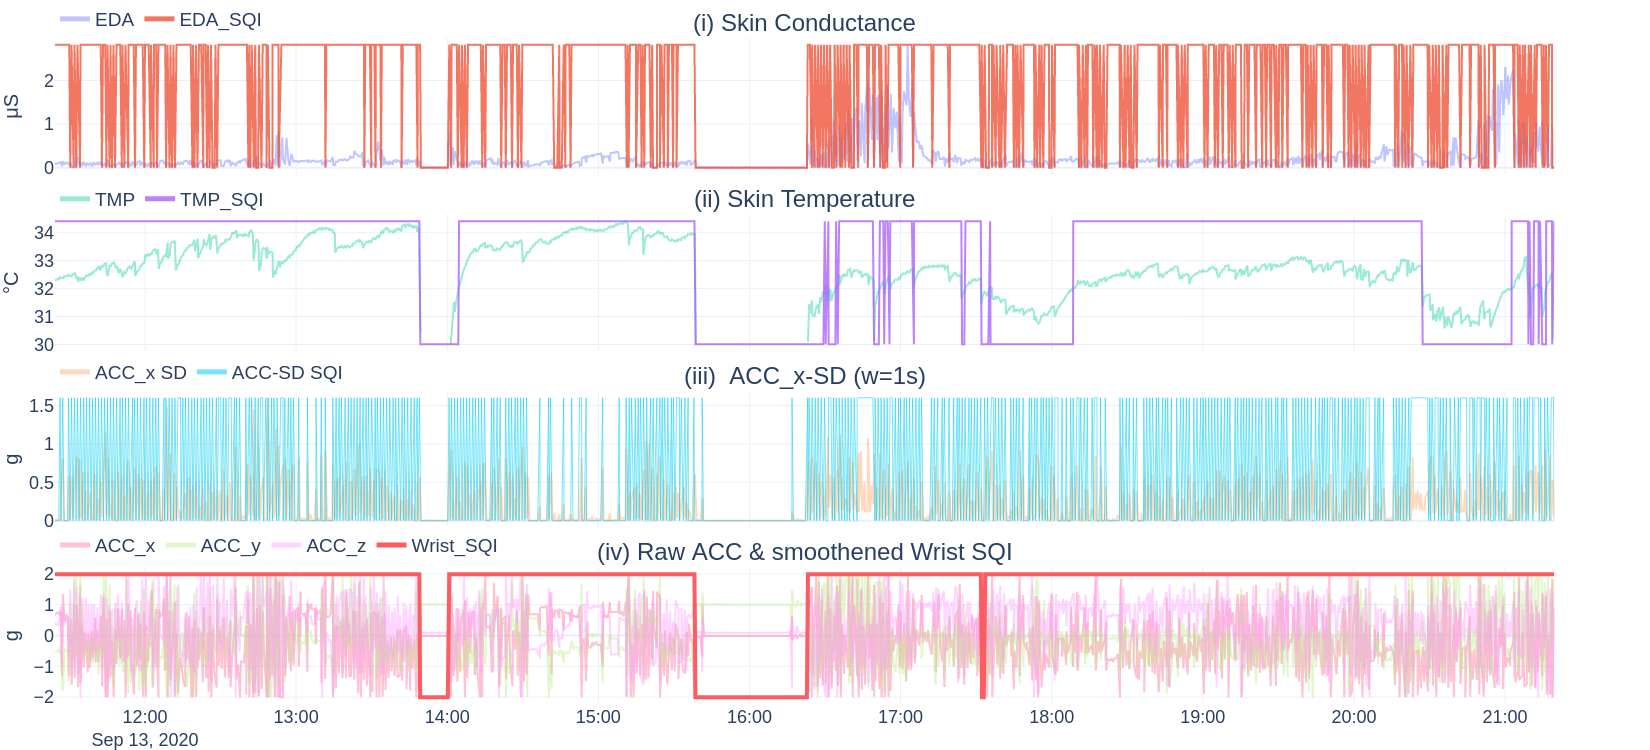

In [4]:
n_rows = 4
if True:
    specs = [[{"secondary_y": True}] for _ in range(n_rows)]
    fig = FigureResampler(
        make_subplots(
            rows=n_rows,
            specs=np.reshape(specs, (-1, 1)).tolist(),
            vertical_spacing=0.06,
            cols=1,
            shared_xaxes=True,
            subplot_titles=[
                "(i) Skin Conductance",
                "(ii) Skin Temperature",
                "(iii)  ACC_x-SD (w=1s)",
                "(iv) Raw ACC & smoothened Wrist SQI",
            ],
        ),
        show_mean_aggregation_size=False,
        resampled_trace_prefix_suffix=("", ""),
    )

# ROW 1 -----------------------------------------------------

for col in df_eda.columns:
    s_c = df_eda[col]
    fig.add_trace(go.Scatter(name=col, opacity=0.4), hf_x=s_c.index, hf_y=s_c)

for col in ["EDA_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.8),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
    )

# ROW 2 -----------------------------------------------------
for col in df_tmp.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, legend="legend2"),
        hf_x=df_tmp[col].index,
        hf_y=df_tmp[col],
        row=2,
        col=1,
    )


for col in ["TMP_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.8, legend="legend2"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
        secondary_y=True,
    )

# ROW 3 -----------------------------------------------------
for col in ["AI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(opacity=0.4, name="ACC_x SD", legend="legend3"),
        hf_x=s_c.index,
        hf_y=s_c,
        row=3,
        col=1,
    )

for col in ["AI_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name="ACC-SD SQI", opacity=0.6, line_width=1, legend="legend3"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
        row=3,
        col=1,
    )


# ROW 4 -----------------------------------------------------
for col in df_acc.columns:
    fig.add_trace(
        go.Scatter(name=f"{col}", opacity=0.4, legend="legend4"),
        hf_x=df_acc[col].index,
        hf_y=df_acc[col] / 64,
        row=4,
        col=1,
    )

for col in ["Wrist_SQI", "On_Wrist_SQI_smoothened"][1:]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(
            name="Wrist_SQI", line_color="#fd5c63", line_width=4, legend="legend4"
        ),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=4,
        col=1,
        secondary_y=True,
    )


# ROW 5 -----------------------------------------------------
# for col in df_bvp.columns:
#     s_c = df_bvp[col]
#     fig.add_trace(
#         go.Scatter(name=col, opacity=0.5), hf_x=s_c.index, hf_y=s_c, row=5, col=1
#     )


# ---------------------- LAYOUT --------------------------------
fig.update_layout(template="plotly_white", height=750)
fig.update_layout(
    legend=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=1.0, x=0, itemsizing="constant"),
    ),
    legend2=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.73, x=0, itemsizing="constant"),
    ),
    legend3=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.47, x=0, itemsizing="constant"),
    ),
    legend4=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.21, x=0, itemsizing="constant"),
    ),
)
fig.update_yaxes(title_text="μS", row=1, col=1, title_font_size=20)
fig.update_yaxes(title_text="°C", row=2, col=1, title_font_size=20)
fig.update_yaxes(title_text="g", row=3, col=1, title_font_size=20)
fig.update_yaxes(title_text="g", row=4, col=1, title_font_size=20)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_annotations(font_size=24)
# update tick sizes
fig.update_xaxes(tickfont_size=18)
fig.update_yaxes(tickfont_size=18)
# do not show seconds on the y-axis
fig.update_yaxes(visible=False, secondary_y=True)

# fig.show_dash(mode="inline", port=9035)
# if USE_PNG:
fig.show(renderer="png", width=1650, height=750)
# fig.write_html(figure_dir / "wrist_on_off.html", include_plotlyjs="cdn", full_html=False)

### Böttcher

In [5]:
out_bottcher = wrist_pipeline_bottcher.process(
    [df_eda, df_tmp, df_acc],
    return_df=False,
    drop_keys=["ACC_x", "ACC_y", "ACC_z", "EDA"],
    logging_file_path="wrist_on_off_.log",
)
# display(out['Wrist_SQI_smoothened'].isna().value_counts())
# out['Wrist_SQI_smoothened'].bfill(inplace=True) #= out['Wrist_SQI_smoothened'].bfill()
pl = get_processor_logs("wrist_on_off_.log").drop(columns=["log_time"])
display(pl)  # , 'duration']))
print(
    round(pl.duration.sum().total_seconds() / (len(df_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)


/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning:

Logging file (wrist_on_off_.log) already exists. This file will be overwritten!



,function,series_names,duration
0,dataframe_func: std_sum,"(ACC_x, ACC_y, ACC_z)",0 days 00:00:00.173462391
1,<lambda>,"(AI,)",0 days 00:00:00.000983477
2,<lambda>,"(EDA,)",0 days 00:00:00.000235081
3,<lambda>,"(TMP,)",0 days 00:00:00.000442028
4,<lambda>,"(EDA_SQI, TMP_SQI)",0 days 00:00:00.001402617
5,<lambda>,"(EDA_SQI, AI_SQI)",0 days 00:00:00.040482521
6,mean_resample,"(EDA_SQI,)",0 days 00:00:00.007754803
7,mean_resample,"(AI_SQI,)",0 days 00:00:00.002427340
8,mean_resample,"(TMP_SQI,)",0 days 00:00:00.002385378
9,mean_resample,"(EDA_SQI,)",0 days 00:00:00.002465487


0.02405 seconds per hour


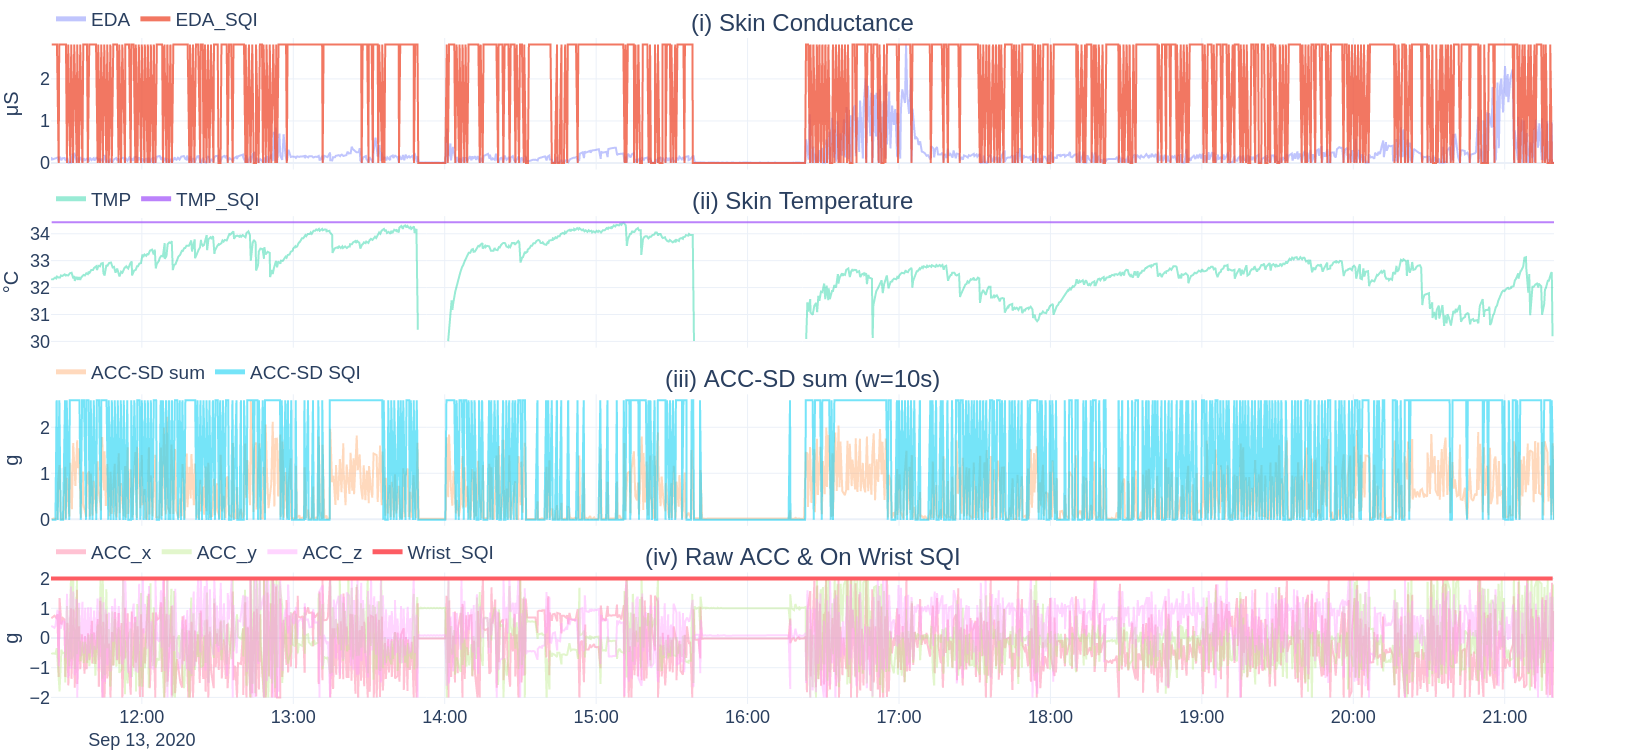

In [6]:
n_rows = 4
if True:
    specs = [[{"secondary_y": True}] for _ in range(n_rows)]
    fig = FigureResampler(
        make_subplots(
            rows=n_rows,
            specs=np.reshape(specs, (-1, 1)).tolist(),
            cols=1,
            shared_xaxes=True,
            subplot_titles=[
                "(i) Skin Conductance",
                "(ii) Skin Temperature",
                "(iii) ACC-SD sum (w=10s)",
                "(iv) Raw ACC & On Wrist SQI",
            ],
            vertical_spacing=0.07,
        ),
        show_mean_aggregation_size=False,
        resampled_trace_prefix_suffix=("", ""),
    )

fig.update_yaxes(range=[-0.05, 1.05], secondary_y=True, row=4, col=1)
fig.update_yaxes(range=[-0.05, 1.05], secondary_y=True, row=3, col=1)
fig.update_yaxes(range=[-0.05, 1.05], secondary_y=True, row=2, col=1)

# ROW 1 -----------------------------------------------------
for col in df_eda.columns:
    s_c = df_eda[col]
    fig.add_trace(go.Scatter(name=col, opacity=0.4), hf_x=s_c.index, hf_y=s_c)


for col in ["EDA_SQI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.8),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
    )

# ROW 2 -----------------------------------------------------
for col in df_tmp.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, legend="legend2"),
        hf_x=df_tmp[col].index,
        hf_y=df_tmp[col],
        row=2,
        col=1,
    )


for col in ["TMP_SQI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.8, legend="legend2"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
        secondary_y=True,
    )

# ROW 3 -----------------------------------------------------
for col in ["AI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name="ACC-SD sum", opacity=0.4, legend="legend3"),
        hf_x=s_c.index,
        hf_y=s_c,
        row=3,
        col=1,
    )

for col in ["AI_SQI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name="ACC-SD SQI", opacity=0.6, line_width=2, legend="legend3"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
        row=3,
        col=1,
    )


# ROW 4 -----------------------------------------------------
for col in df_acc.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, legend="legend4"),
        hf_x=df_acc[col].index,
        hf_y=df_acc[col] / 64,
        row=4,
        col=1,
    )

for col, row_idx in [("EDA_SQI_mean", 1), ("AI_SQI_mean", 3), ("TMP_SQI_mean", 2)][:0]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(
            name=col, legend="legend" + {2: "2", 3: "3", 4: "4"}.get(row_idx, "")
        ),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=row_idx,
        col=1,
        secondary_y=True,
        limit_to_view=True,
    )


# ROW 4 -----------------------------------------------------
for col, row_idx in [ ("On_Wrist_SQI", 4)]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(
            name='Wrist_SQI',
            line_width=4 if "wrist_sqi" in col.lower() else 2,
            line_color="#fd5c63" if "wrist_sqi" in col.lower() else None,
            legend="legend" + {2: "2", 3: "3", 4: "4"}.get(row_idx, ""),
        ),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
        limit_to_view=True,
        row=row_idx,
        col=1,
    )


# ------------------------- LAYOUT --------------------------------
fig.update_layout(template="plotly_white", height=750)
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=0.95,
        font_size=17,
        itemsizing="constant",
    )
)

fig.update_layout(template="plotly_white", height=750)
fig.update_layout(
    legend=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=1.0, x=0, itemsizing="constant"),
    ),
    legend2=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.73, x=0, itemsizing="constant"),
    ),
    legend3=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.47, x=0, itemsizing="constant"),
    ),
    legend4=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.20, x=0, itemsizing="constant"),
    ),
)
fig.update_yaxes(title_text="μS", row=1, col=1, title_font_size=20)
fig.update_yaxes(title_text="°C", row=2, col=1, title_font_size=20)
fig.update_yaxes(title_text="g", row=3, col=1, title_font_size=20)
fig.update_yaxes(title_text="g", row=4, col=1, title_font_size=20)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_annotations(font_size=24)
fig.update_xaxes(tickfont_size=18)
fig.update_yaxes(tickfont_size=18)
fig.update_yaxes(visible=False, secondary_y=True)
fig.show(renderer="png", width=1650, height=750)
